# Jake Lydon Workist Task

**Notes:**

- I don't typically use Jupyter Notebooks, so this (wrt the notebook) was a bit of a learning experience for me.
- I timeboxed this task to about 3 hours or so for the dev/training but documentation/visualization took a few extra hours.
    - This involved cutting a few corners and making some educated assumptions.
    - Typically I would write a custom dataset class.
    - Typically I would do a hyperparam search.
    - Typically I would spend a lot of time researching architectures and experimenting with different ones.
    - Typically I would hook up monitoring on Tensorboard.
        - Many at my office have recently switched to Weights & Biases for monitoring and managing training, and I am planning to switch as well on my next project because its awesome.
- I don't have much experience with NLP (though I would like to learn) so I kept this as a vision task.


## Imports

Nothing fancy here - just some imports at the top of the code.

I had to install tensorflow_addons for the triplet loss as well:

    pip install -q -U tensorflow-addons

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Data Loading and Exploration

## Data Loading

- I used the keras built in image_dataset_from_directory() function for the sake of brevity. 
    - Classes are not guaranteed to be balanced but upon inspection they are close.
- I chose a 60/40 train/val split so there would be a good number of documents to evaluate on.
- With a fairly large dataset I would split maybe 80/15/5 train/val/test.
- Also used a strange batch sizes (20 train and 40 val) because of the small dataset.
    - Typically would use 16, 32, 64 in most cases.

In [56]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

data_dir = "data"
train_batch_size = 20  
val_batch_size = 40  
val_split = 0.4
img_height = 224  # Default size for mobilenetv3
img_width = 224  # Default size for mobilenetv3
seed = 123

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="training",
    seed=123,
    batch_size=train_batch_size,
    image_size=(img_height, img_width)
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="validation",
    seed=123,
    batch_size=val_batch_size,
    image_size=(img_height, img_width)
)

print(train_ds.class_names)
print(train_ds)


Found 100 files belonging to 4 classes.
Using 60 files for training.
Found 100 files belonging to 4 classes.
Using 40 files for validation.
['email', 'invoice', 'letter', 'resumee']
<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


## Visualize 20 samples from the validation set

Its always a good idea to visualize a sample of your data first thing, before going any further.

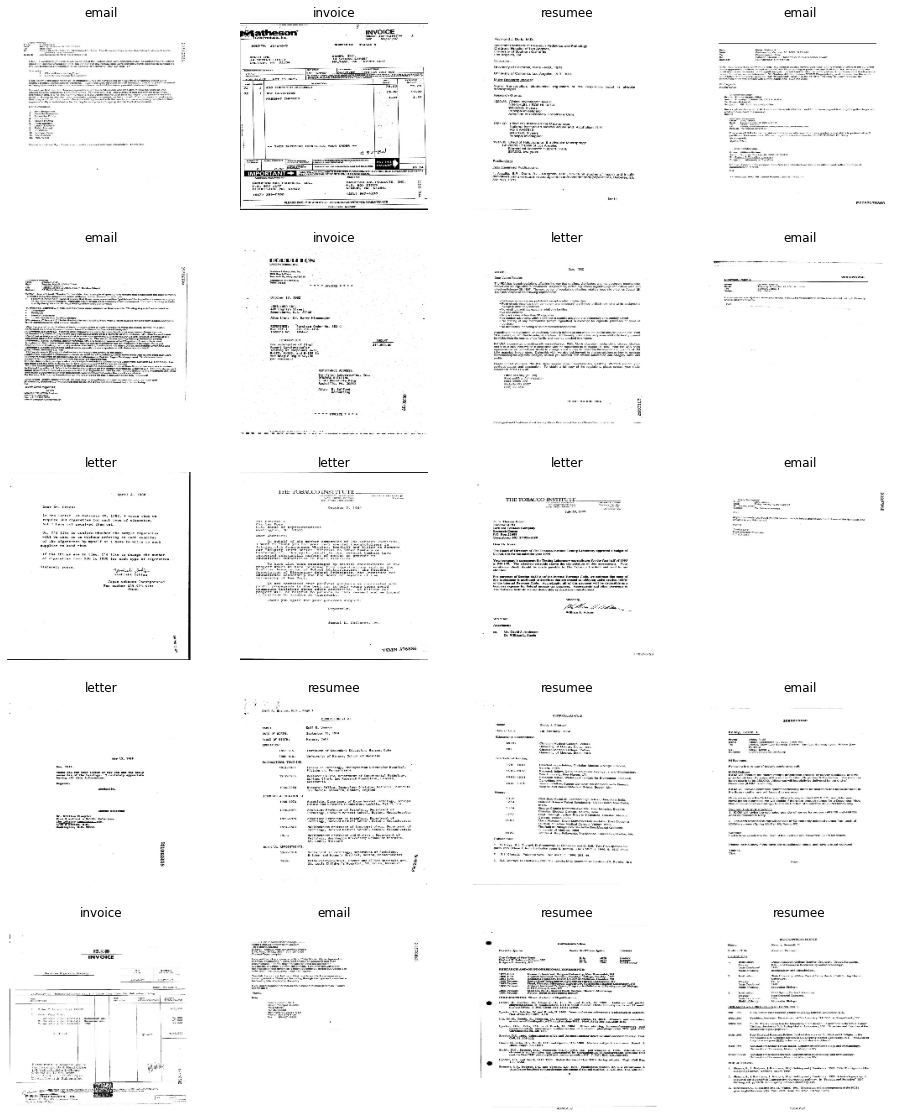

In [57]:
# Modified from tensorflow tutorial.

class_names = val_ds.class_names
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(16, 20))
for i in range(20):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


## Training set distributions

Quick check to make sure the classes aren't unbalanced. Again, typically I would have created a custom dataloader to guarantee balance train/val distributions (since I know there are 25 of each class).

[2 2 1 2 0 0 1 0 2 0 1 1 2 0 0 0 3 2 1 3 2 1 1 1 3 0 3 3 1 0 3 0 2 0 0 3 2
 0 1 3 3 3 3 1 3 3 2 3 0 2 1 0 3 1 1 2 2 2 0 3]


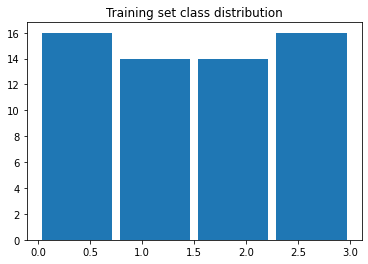

In [58]:
train_labels = np.array([label.numpy() for data, label in train_ds]).flatten()
print(train_labels)
plt.hist(
    train_labels, 
    density=False, 
    bins=4, 
    rwidth=0.9
)
plt.title("Training set class distribution")
plt.show()

[0 3 1 1 1 3 3 3 3 1 0 2 2 0 2 0 1 2 2 1 1 0 1 2 0 1 2 0 2 3 2 0 1 2 2 3 3
 3 0 1]


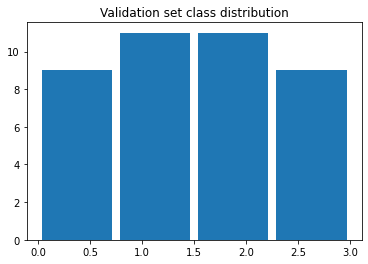

In [59]:
val_labels = np.array([label.numpy() for data, label in val_ds]).flatten()
print(val_labels)
plt.hist(
    val_labels, 
    density=False, 
    bins=4, 
    rwidth=0.9
)
plt.title("Validation set class distribution")
plt.show()

# Quick 10 min Research

- Though most document classification models are multimodal or NLP-based, I limited my research to vision-based approaches.
- There were many very accurate models on the Papers With Code RVL-CDIP Leaderboard
    - https://paperswithcode.com/sota/document-image-classification-on-rvl-cdip
    - I noticed all of the newer methods were multimodal but there are vision-based models from a few years ago.
- I found a blog post where they experimented with imagenet trained ResNet and VGG-16 vs non-pretrained versions on the RVL-CDIP dataset.
    - https://labs.imaginea.com/visual-classification-of-document-images/
    - The imagenet pretrained models performed much better.
- These quick insights were enough for me to get started with a simple pretrained image-based approach.

# Model Building, Training, and Evaluation

After my quick research, I had a good idea that a simple classification network with a backbone trained on imagenet can work for this task. However, given the scarcity of data I wanted to utilize my experience with siamese triplet networks to strengthen the embeddings before classification. 

The simple architecture I came up with is as follows:
Mobilenetv3small trained on imagenet -> image embedding (triplet loss) -> classification (cross entropy loss)

A few comments:
- I chose Mobilenetv3small because its small and I was resource and time constrained.
    - Typically I would experiment with many different backbones in a transfer learning task.
- I found that enforcing stronger embeddings with the triplet loss raised validation accuracy by roughly 10%.
- Depending on the run, accuracy on the validation set is around 90%.

## Tensorflow imports

Typically I like to have all imports at the top of a model.py to make the code easier to read.

In [60]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.activations import swish
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomRotation, RandomTranslation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow_addons.losses import TripletSemiHardLoss

## Transfer Learning from Imagenet

I used the mobilenetv3small trained on imagenet as the backbone because it is very small.

In [61]:
base_model = MobileNetV3Small(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = True

## Build Model

- In tensorflow I prefer to use the keras functional api because it is much more flexible and powerful than the sequential api. 
- I also like these in-model augmentations for simple models like this.
- Since we need to enforce the strong embeddings due to limited data, we have 2 outputs.
- In the end we have a small model with only ~8 million params.

In [65]:
inputs = Input(shape=(img_height, img_width, 3))

# On demand in-model augmentation (except for rescaling, only in training)
rescale = Rescaling(1 / 255.)(inputs)
rotate = RandomRotation(0.02)(rescale)
translation = RandomTranslation((-0.05, 0.05), (-0.05, 0.05))(rotate)

# Complete model architecture
base = base_model(translation, training=True)
batch = BatchNormalization()(base)
drop = Dropout(0.2)(batch)
flat = Flatten()(drop)
emb = Dense(128, name="embedding")(flat)
emb_swish = swish(emb)
cat = Dense(4, name="cat")(emb_swish)

model = Model(inputs, [emb, cat])

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation_4 (Random (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 1024)        4096      
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 1024)        0   

## Train Model

- Though I enforce the strong embeddings with the triplet loss, we really only care about the classification in the end.
    - Therefore the training monitors validation accuracy and saves the model that maximizes this metric.
- I slowed the default learning rate to 0.0005 because the triplet loss tends toward 0 very fast with this little data.

In [14]:
checkpoint = ModelCheckpoint(
    'workist_model.h5', 
    verbose=1,
    monitor="val_cat_accuracy", 
    save_best_only=True, 
    mode='max',
    save_weights_only=False
)

model.compile(
    optimizer=Adam(0.0005),
    loss=[TripletSemiHardLoss(), SparseCategoricalCrossentropy(from_logits=True)],
    metrics=['accuracy']
)

model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=checkpoint
)

Epoch 1/40
3/3 [==============================] - 6s 828ms/step - loss: 3.0178 - embedding_loss: 0.6909 - cat_loss: 2.3270 - embedding_accuracy: 0.0000e+00 - cat_accuracy: 0.5000 - val_loss: 3.4652 - val_embedding_loss: 0.2693 - val_cat_loss: 3.1959 - val_embedding_accuracy: 0.0000e+00 - val_cat_accuracy: 0.6000

Epoch 00001: val_cat_accuracy improved from -inf to 0.60000, saving model to workist_mode1.h5


/home/jake/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/40
3/3 [==============================] - 1s 483ms/step - loss: 0.6216 - embedding_loss: 0.1557 - cat_loss: 0.4659 - embedding_accuracy: 0.0000e+00 - cat_accuracy: 0.8000 - val_loss: 4.8967 - val_embedding_loss: 0.1927 - val_cat_loss: 4.7040 - val_embedding_accuracy: 0.0000e+00 - val_cat_accuracy: 0.5000

Epoch 00002: val_cat_accuracy did not improve from 0.60000
Epoch 3/40
3/3 [==============================] - 1s 484ms/step - loss: 0.3249 - embedding_loss: 0.1793 - cat_loss: 0.1456 - embedding_accuracy: 0.0000e+00 - cat_accuracy: 0.9667 - val_loss: 3.9770 - val_embedding_loss: 0.1632 - val_cat_loss: 3.8137 - val_embedding_accuracy: 0.0000e+00 - val_cat_accuracy: 0.5250

Epoch 00003: val_cat_accuracy did not improve from 0.60000
Epoch 4/40
3/3 [==============================] - 1s 468ms/step - loss: 0.1155 - embedding_loss: 0.0330 - cat_loss: 0.0825 - embedding_accuracy: 0.0000e+00 - cat_accuracy: 0.9500 - val_loss: 3.1158 - val_embedding_loss: 0.1491 - val_cat_loss: 2.9667 - 

## Evaluate Model

I was able to get to 90% accuracy on the validation set without much tuning of the network, which seems pretty good to me given the 60/40 data split. I would be really interested to see how training a model like this with more data could perform in the wild.

Accuracy: 36/40 (90.0%)


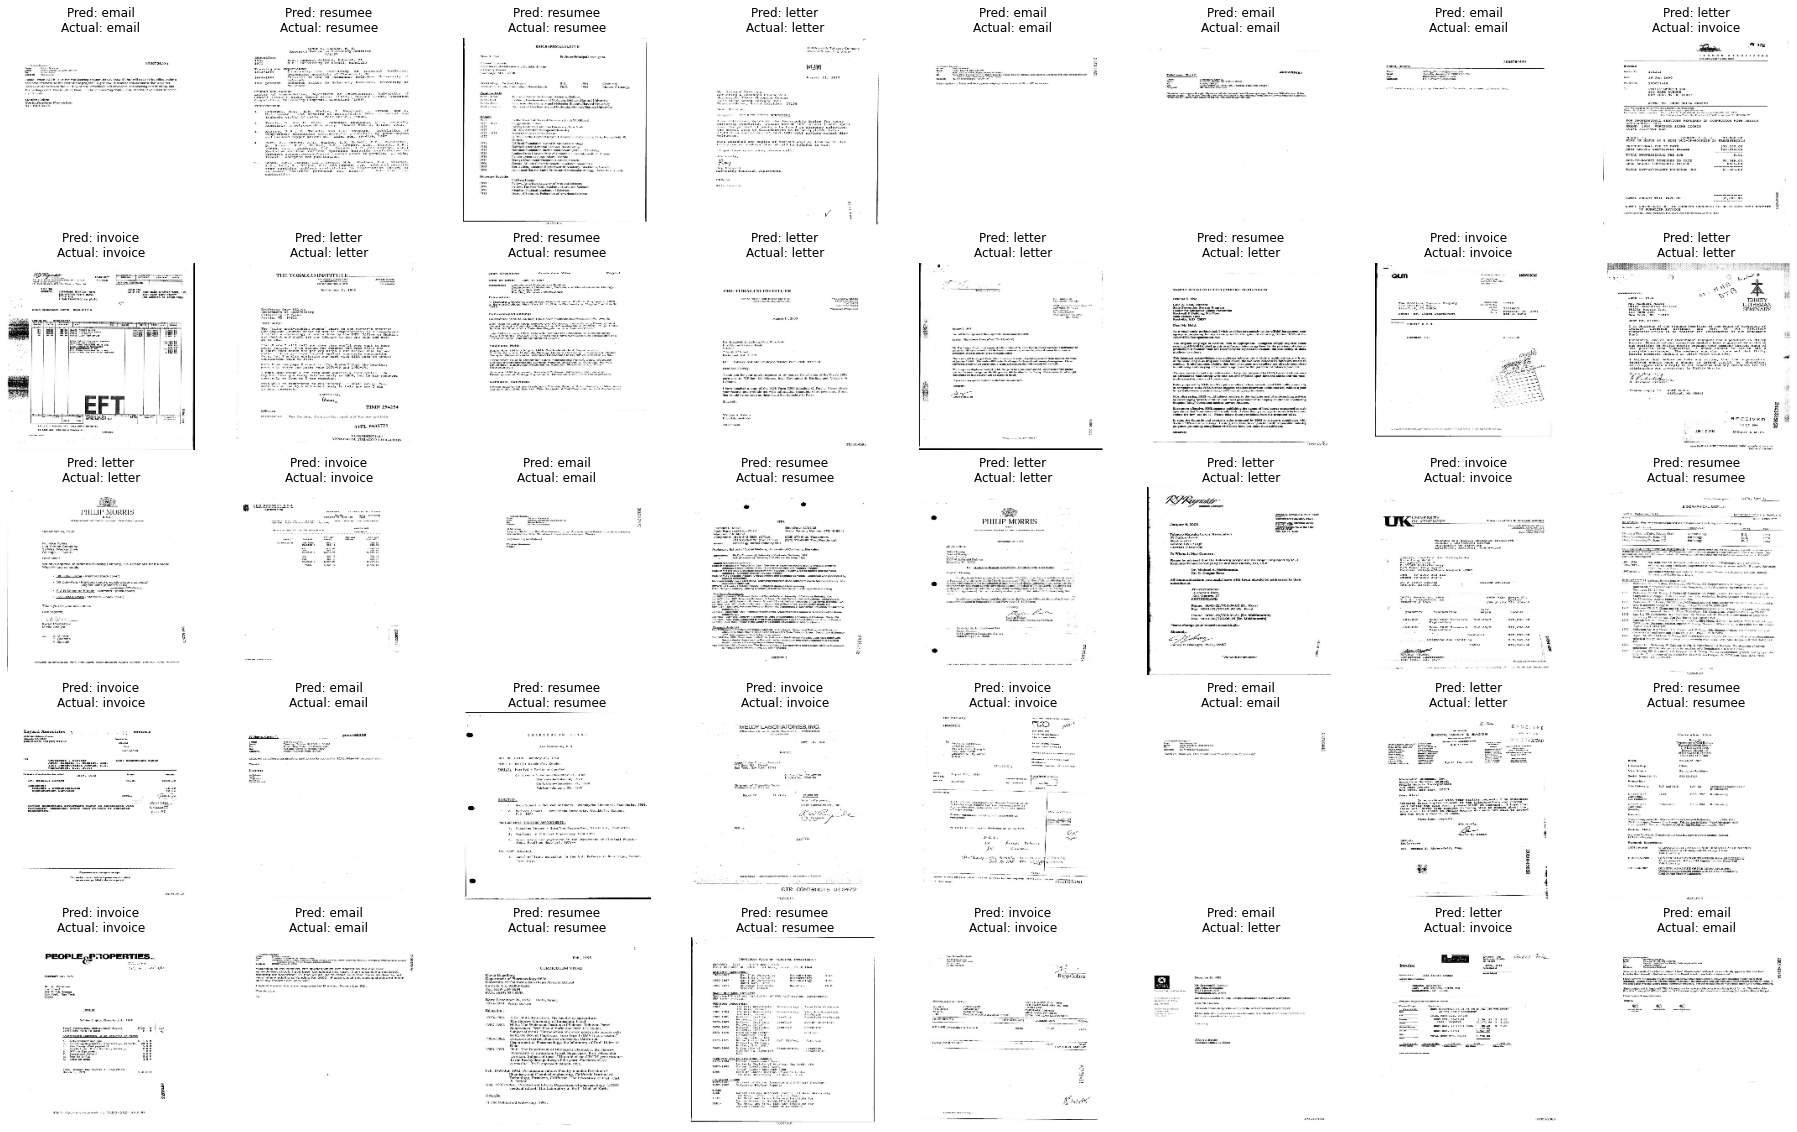

In [67]:
model = load_model("workist_model.h5")

# Explicitly call next batch so we can print with predicted labels.
image_batch, label_batch = next(iter(val_ds))
pred = model.predict(image_batch)  

plt.figure(figsize=(32, 20))

correct_count = 0
for i in range(40):
    ax = plt.subplot(5, 8, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))

    pred_label = class_names[np.argmax(pred[1][i, :])]  # Model outputs [embeddings, labels]
    gt_label = class_names[label_batch[i]]

    if pred_label == gt_label:
        correct_count += 1

    plt.title(f"Pred: {pred_label}\nActual: {gt_label}")
    plt.axis("off")

print(f"Accuracy: {correct_count}/{val_batch_size} ({correct_count/val_batch_size * 100}%)")

## Visualize Embeddings

Even though it was a secondary learning task, I also wanted to check the T-SNE projection of the embeddings from the Tensorboard projector to see how well they are clustered. This image is the validation set embeddings.

- One interesting note:
    - There are 5 samples clustered improperly but only 4 were labeled wrongly. Not sure what this means but I find it interesting.

In [75]:
# Modified from tensorflow embeddings projector tutorial

import os
import tensorflow as tf
from tensorboard.plugins import projector

log_dir = "logs"
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for label in label_batch:
    f.write("{}\n".format(label))

weights = tf.Variable(pred[0])

# Create a checkpoint from embeddings
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

<img src="Embeddings-visualization.png">